## Вероятностная рейтинг-система для “Что? Где? Когда?”

Загрузим данные и посмотрим на них

In [1]:
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.stats import spearmanr, kendalltau
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [2]:
tournaments = pickle.load(open("chgk/tournaments.pkl", "rb"))
results = pickle.load(open("chgk/results.pkl", "rb"))
players = pickle.load(open("chgk/players.pkl", "rb"))

In [3]:
# Создаем словарики игр
train_tour = {k:v for k, v in tournaments.items() if v["dateStart"][:4] == "2019"}
test_tour  = {k:v for k, v in tournaments.items() if v["dateStart"][:4] == "2020"}

In [11]:
print(results[6255][0]["mask"])
print([p["player"]["id"] for p in results[6255][0]["teamMembers"]])

1011111111111111011111111110101011111111001011111111011111111011101110011111111111111011111011111111111111111111111011111011111011011011101110111111111110111111111011111111111111111X1011111111111010111001111011101101
[2322, 4875, 13638, 35861, 40391, 53126]


In [35]:
train_tour[6255]

{'id': 5465,
 'name': 'Чемпионат России',
 'dateStart': '2019-05-18T12:00:00+03:00',
 'dateEnd': '2019-05-19T18:00:00+03:00',
 'type': {'id': 2, 'name': 'Обычный'},
 'season': '/seasons/52',
 'orgcommittee': [{'id': 31038,
   'name': 'Владимир',
   'patronymic': 'Владимирович',
   'surname': 'Сушков'},
  {'id': 26469,
   'name': 'Алексей',
   'patronymic': 'Владимирович',
   'surname': 'Рабин'},
  {'id': 25882,
   'name': 'Максим',
   'patronymic': 'Оскарович',
   'surname': 'Поташев'},
  {'id': 144,
   'name': 'Сергей',
   'patronymic': 'Леонидович',
   'surname': 'Абрамов'}],
 'synchData': None,
 'questionQty': {'1': 15, '2': 15, '3': 15, '4': 15, '5': 15, '6': 15}}

In [33]:
# Возьмем результаты игроков на тейне и тесте
train_players = set()
for tour_id in train_tour:
    for team in results[tour_id]:
         train_players.update(set([p["player"]["id"] for p in team["teamMembers"]]))
            
test_players = set()
for tour_id in test_tour:
    for team in results[tour_id]:
         test_players.update(set([p["player"]["id"] for p in team["teamMembers"]]))

In [34]:
print(len(train_players))
print(len(test_players))

59224
29447


## Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:

* повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
*  в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


будем считать, что игрок ответил на вопрос, если на вопрос ответила его команда.

сложность каждого вопроса определим как отношение количества игроков ответивших на вопрос к количеству игроков в турнире

In [68]:
question_rating = dict()
data_question = {"id_player": [], "id_question": [], "answered": []}
for tour_id in train_tour.keys():
    unique_players_tour = set()
    for comand in results[tour_id]:
        for player in comand["teamMembers"]:
            unique_players_tour.add(player["player"]["id"])
    count_players = len(unique_players_tour) # количество игроков в туринире
    
    # будем считать, что все вопросы идут подряд, просто некоторые команды не успевают на них ответить
    # Вычислим самую длинну последовательность ответов:
    answs = [comand["mask"] for comand in results[tour_id] if ('mask' in comand.keys() and comand["mask"] is not None)]
    if len(answs) > 0:
        seq_max = max(answs, key=len)
    else:
        seq_max = []
    
    # id вопроса это туринир + номер в длинной последовательности
    all_question_ids = [f"{tour_id}_" + str(i) for i in range(len(seq_max))]
    questions_answered = [0] * len(seq_max)
    
    for comand in results[tour_id]:
        if 'mask' in comand.keys() and comand["mask"] is not None:
            
            players = [p["player"]["id"] for p in comand["teamMembers"]]
            for i, answer in enumerate(comand["mask"]):
                if answer == "1":
                    questions_answered[i] += len(players)
                    
                for player in players:
                    data_question["id_player"].append(player)
                    data_question["id_question"].append(all_question_ids[i])
                    data_question["answered"].append(1 if answer == "1" else 0)
                    
    for i, q_id in enumerate(all_question_ids):
        if count_players > 0:
            question_rating[q_id] = questions_answered[i] / count_players      
        
            
question_rating = pd.DataFrame({"id_question": list(question_rating.keys()), 
                                "question_rating": list(question_rating.values())})
data_question = pd.DataFrame(data_question)
data_question = data_question.merge(question_rating, on='id_question')

In [73]:
data_question

,id_player,id_question,answered,question_rating
0,6212,4772_0,1,0.892295
1,18332,4772_0,1,0.892295
2,18036,4772_0,1,0.892295
3,22799,4772_0,1,0.892295
4,15456,4772_0,1,0.892295
...,...,...,...,...
21014262,201802,6255_215,0,0.028529
21014263,207830,6255_215,0,0.028529
21014264,207831,6255_215,0,0.028529
21014265,207832,6255_215,0,0.028529


Построим распределение сложности вопроса

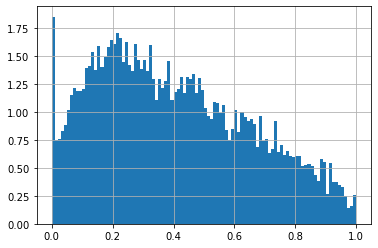

In [84]:
density = plt.hist(data_question["question_rating"].sample(1000000), bins=100, density=True)
plt.grid()

Найдем рейтинг каждого игрока.

Обучим логистичесскую регрессию предсказывать вероятность $p_i$ ответить игроком на вопрос используя единственный признак - сложность вопроса.

рейтинг игрока определим как матожидание от вероятности ответить по распределению сложности вопросов

In [86]:
data_question["rating_player"] = None

In [88]:
data_question

,id_player,id_question,answered,question_rating,rating_player
0,6212,4772_0,1,0.892295,None
1,18332,4772_0,1,0.892295,None
2,18036,4772_0,1,0.892295,None
3,22799,4772_0,1,0.892295,None
4,15456,4772_0,1,0.892295,None
...,...,...,...,...,...
21014262,201802,6255_215,0,0.028529,None
21014263,207830,6255_215,0,0.028529,None
21014264,207831,6255_215,0,0.028529,None
21014265,207832,6255_215,0,0.028529,None


In [ ]:
data_idxs = data_question.groupby("id_player").groups

In [104]:
model = LogisticRegression(C=100, solver="lbfgs", n_jobs=8)
for player in tqdm(data_idxs):
    data = data_question.iloc[data_idxs[player]]
    data_X = data[["question_rating"]]
    data_y = data["answered"]
    if np.unique(data_y).shape[0] > 1:
        model.fit(data_X, data_y)
        predict = model.predict_proba(np.arange(0, 1, 0.01).reshape(-1, 1))[:, 1]
        rating = predict @ density[0] * 0.01 # 0,01 - это шаг гистограммы
    else:
        rating = data_y.values[0]
    data_question.loc[data_idxs[player]]["rating_player"]

In [105]:
data_question

,id_player,id_question,answered,question_rating,rating_player
0,6212,4772_0,1,0.892295,0.68569
1,18332,4772_0,1,0.892295,0.713548
2,18036,4772_0,1,0.892295,0.705089
3,22799,4772_0,1,0.892295,0.686306
4,15456,4772_0,1,0.892295,0.655265
...,...,...,...,...,...
21014262,201802,6255_215,0,0.028529,0.103903
21014263,207830,6255_215,0,0.028529,0.0882181
21014264,207831,6255_215,0,0.028529,0.0799256
21014265,207832,6255_215,0,0.028529,0.0976358


<AxesSubplot:>

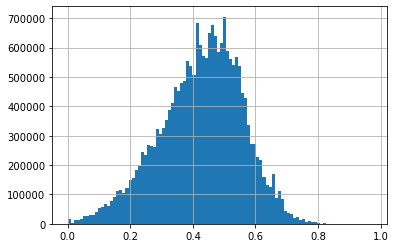

In [107]:
# Посмотрим на гистограмму полученного рейтинга
data_question['rating_player'].hist(bins=100)

In [106]:
data_question.to_csv("data_with_rating.csv", index=False)

In [110]:
# Для удобства сохраним словарик игрок-рейтинг
raiting_dict = dict(data_question.drop_duplicates("id_player")[["id_player","rating_player"]].values)

In [116]:
# найдем средний рейтинг
mean_rating = np.mean(list(raiting_dict.values()))
mean_rating

0.3294623870123657

*TASK*: Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
* предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
* в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете ​scipy)​между реальным ранжированием в результатах турнира и предсказанным
1 моделью, усреднённые по тестовому множеству турниров.

*ANS*:

Отранжируем команды по рейтингу (т.е по вероятности ответить на случайный вопрос из базы). 
Вероятность команды ответить на вопрос вычислим из рейтинга состава команды: 
    
$R = 1 - \prod\limits_{i\in T} (1 - r_i)$

* $r_i$ - рейтинг $i$ - го игрока 
* $T$ - состав команды
* $R$ - рейтинг команды

In [117]:
def command_rank(command, raitings):
    inv_rate = 1
    players = [p["player"]["id"] for p in command]
    for player in players:
        if player in raitings.keys():
            inv_rate = inv_rate * (1 - raiting_dict[player])
        else:
            inv_rate = inv_rate * (1 - mean_rating)
    return 1 - inv_rate

In [120]:
SPEARMAN = []
KENDALL = []
for tour in test_tour.keys():
    
    ranks_true = []
    ranks_pred = []
    
    for command in results[tour]:
        if 'position' in command.keys() and 'teamMembers' in command.keys():
            ranks_true.append(-command['position'])
            ranks_pred.append(command_rank(command['teamMembers'], raiting_dict))
    spearman_coef = spearmanr(ranks_true, ranks_pred)[0]
    kendall_coef = kendalltau(ranks_true, ranks_pred)[0]
    
    if not np.isnan(spearman_coef):
        SPEARMAN.append(spearman_coef)
    if not np.isnan(kendall_coef):
        KENDALL.append(kendall_coef)
        
print(f"Mean spearman coeff: {np.mean(SPEARMAN)}, mean kendall coeff: {np.mean(KENDALL)}")

Mean spearman coeff: 0.6573543029261981, mean kendall coeff: 0.5047316974436908


*TASK*: Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
* предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
* разработайте EM-схему для обучения этой модели, реализуйте её в коде;
* обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

Для начала запишем id команд

In [122]:
def id_2_id(id_):
    return int(id_.split("_")[0])
data_question["team_id"] = data_question["id_question"].apply(id_2_id)

In [123]:
data_question

,id_player,id_question,answered,question_rating,rating_player,team_id
0,6212,4772_0,1,0.892295,0.68569,4772
1,18332,4772_0,1,0.892295,0.713548,4772
2,18036,4772_0,1,0.892295,0.705089,4772
3,22799,4772_0,1,0.892295,0.686306,4772
4,15456,4772_0,1,0.892295,0.655265,4772
...,...,...,...,...,...,...
21014262,201802,6255_215,0,0.028529,0.103903,6255
21014263,207830,6255_215,0,0.028529,0.0882181,6255
21014264,207831,6255_215,0,0.028529,0.0799256,6255
21014265,207832,6255_215,0,0.028529,0.0976358,6255


In [18]:
p_init = X["rating_player"].values

Составим функцию правдоподобия

$P(D|\Theta) = \prod\limits_{i\in T}\prod\limits_{j\in Q}\prod\limits_{k\in K}p_{k,i}(\theta)^{z_{i,j,k}}(1-p_{k,i}(\theta))^{1-z_{i,j,k}}$

где:

* $z_{i,j,k}$ - вектор скрытых переменных. на k-м месте стоит 1, если k-й игрок дал верный ответ и 0 если не дал верного ответа
* $T$ - множеcтво команд

* $Q$ - множество вопросов

* $K$ множество игроков в команде

Тогда на E шаге EM алгоритма мы оцениваем параметры $z_{i,j,k}$, а на M шаге - максимизируем правдоподобие $P(D|\Theta)$ используя вместо истинных z - их мат ожидание. Параметры $\Theta$ будут определять "силу" игрока и сложность вопросов (два вектора в стык, размерность, соотвественно len(players) + len(questions)). функция $p_{k,i}(\theta)$ все та же сигмоида.

Оценить параметры $z_{i,j,k}$ можно по теореме Байеса:

$P(Ans_i|A_T) = \dfrac{P(Ans_T|Ans_i)P(Ans_i)}{P(Ans_T)} = \dfrac{P(Ans_i)}{P(Ans_T)} = \dfrac{P(Ans_i)}{1 - \prod\limits_{j \in K} (1 - P(Ans_j))}$


Где событие $Ans_i$ - игрок с номером $i$ ответил на вопрос, событие $Ans_T$ - команда ответила на вопрос

данные об ответах, соответсвенно, используются неявно: если команда не ответила, то все скрытые переменные зануляются, если кто-то ответил, то $P(Ans_T|Ans_i)=1$ 

In [129]:
#one-hot encode indexes of player and question 
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(data_question[['id_player', 'id_question']])
sparce_matrix = encoder.transform(data_question[['id_player', 'id_question']])
counts = np.array((sparce_matrix != 0).sum(axis=0)).ravel()

#theta = сила игрока и сложность вопроса
theta = np.random.randn(sparce_matrix.shape[1])
p_player_to_answer = 1 / (1 + np.exp(-sparce_matrix.dot(theta))) 

data_question['negative_prob'] = 1 - p_player_to_answer
m_df = data_question[['team_id', 'id_question', 'negative_prob']].groupby(by=['team_id', 'id_question'], sort=False, as_index=False).prod()
from_id = (m_df['team_id'].apply(str) + m_df['id_question'].apply(str)).apply(int)
to_id = (data_question['team_id'].apply(str) + data_question['id_question'].apply(str)).apply(int)

In [137]:
data_question

,id_player,id_question,answered,question_rating,rating_player,team_id,negative_prob
0,6212,4772_0,1,0.892295,0.68569,4772,0.151106
1,18332,4772_0,1,0.892295,0.713548,4772,0.279038
2,18036,4772_0,1,0.892295,0.705089,4772,0.114934
3,22799,4772_0,1,0.892295,0.686306,4772,0.052423
4,15456,4772_0,1,0.892295,0.655265,4772,0.308691
...,...,...,...,...,...,...,...
21014262,201802,6255_215,0,0.028529,0.103903,6255,0.823291
21014263,207830,6255_215,0,0.028529,0.0882181,6255,0.863519
21014264,207831,6255_215,0,0.028529,0.0799256,6255,0.598981
21014265,207832,6255_215,0,0.028529,0.0976358,6255,0.587710


In [148]:
def e_step(p_player_to_answer):
    data_question['negative_prob'] = 1 - p_player_to_answer
    prods = data_question[['team_id', 'id_question', 'negative_prob']].groupby(by=['team_id', 'id_question'], sort=False, as_index=False).prod()['negative_prob']
    prods.index = from_id
    prods = prods[to_id].to_numpy()
    z_hidden = p_player_to_answer / (1 - prods)
    z_hidden[data_question['answered'] == 0] = 0 # Никто не дал верного ответа. По умолчанию предполагается, что ответ дан
    return z_hidden

def m_step(sparce_matrix, theta, z_hidden, iterations=30, alpha=2):
    theta = theta.copy()
    for i in range(iterations):
        p_player_to_answer = 1 / (1 + np.exp(-sparce_matrix.dot(theta)))
        #Градиентный спуск
        theta = theta + alpha * ((sparce_matrix.T).dot(z_hidden * (1 - p_player_to_answer) - (1 - z_hidden) * p_player_to_answer) / counts)
    return theta

def likelihood(z_hidden, sparce_matrix, theta):
    p_player_to_answer = 1 / (1 + np.exp(-sparce_matrix.dot(theta)))
    return np.mean(z_hidden * np.log(p_player_to_answer) + (1 - z_hidden) * np.log(1 - p_player_to_answer))

In [149]:
iterations = 10
for i in tqdm(range(iterations)):
    if i == 0:
        p_player_to_answer = 1 / (1 + np.exp(-sparce_matrix.dot(theta)))
        z_hidden = e_step(p_player_to_answer)
    theta = m_step(sparce_matrix, theta, z_hidden)
    p_player_to_answer = 1 / (1 + np.exp(-sparce_matrix.dot(theta)))
    z_hidden = e_step(p_player_to_answer)
    print('Итерация: ', i)
    print('Логарифм правдоподобия:', likelihood(z_hidden, sparce_matrix, theta))
    print('\n')

Итерация:  0
Логарифм правдоподобия: -0.32167344245111557


Итерация:  1
Логарифм правдоподобия: -0.22650721401462076


Итерация:  2
Логарифм правдоподобия: -0.1775445453188482


Итерация:  3
Логарифм правдоподобия: -0.14705974099644897


Итерация:  4
Логарифм правдоподобия: -0.12611592866572696


Итерация:  5
Логарифм правдоподобия: -0.11079174521053305


Итерация:  6
Логарифм правдоподобия: -0.09907148093569806


Итерация:  7
Логарифм правдоподобия: -0.08980706153272415


Итерация:  8
Логарифм правдоподобия: -0.08229475954648957


Итерация:  9
Логарифм правдоподобия: -0.07607814604322664





In [154]:
# выудим значения силы игроков и сложнсти вопросов
index = []
for feat in encoder.get_feature_names():
    index.append(feat[3:])

em_weight_player = {}
for player in data_question.id_player.unique():
    em_weight_player[player] = theta[index.index(str(player))]

em_question = {}
for q in data_question.id_question.unique():
    em_question[q] = theta[index.index(q)]

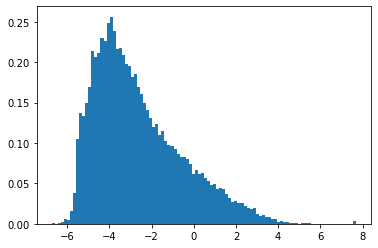

In [155]:
density = plt.hist(em_question.values(), bins=100, density=True)

In [159]:
data_question["rating_player_em"] = None

In [186]:
# Тогда рейтинг игрока это средняя сила игрока с учетом сложности вопроса
raiting_em_dict = {}
for player in tqdm(data_question.id_player.unique()):
    predict = 1 / (1 + np.exp(-(em_weight_player[player] + density[1][:100])))
    rating = predict @ density[0] * 0.01
    raiting_em_dict[player] = rating

In [187]:
mean_rating = np.mean(list(raiting_em_dict.values()))
mean_rating

0.0018274360674310573

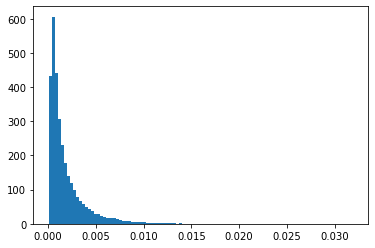

In [189]:
_ = plt.hist(list(raiting_em_dict.values()), bins=100, density=True)

In [224]:
spearmans = []
kendalls =[]

for tour_id in tqdm(test_tour):
    if  results[tour_id]:
        if 'position' in results[tour_id][0].keys():
            true_team_ranks=[]
            predicted_team_ranks=[]

            for _, team in enumerate(results[tour_id]):
                true_team_ranks.append(team['position'])

                prob_to_answer_wrong = 1
                for player in team['teamMembers']:
                    player_id = player['player']['id'] 
                    if player_id in raiting_em_dict:
                        player_rating = raiting_em_dict[player_id]
                    else:
                        player_rating = mean_rating
                    prob_to_answer_wrong *= (1 - player_rating)
                predicted_team_ranks.append(1 - prob_to_answer_wrong)
                               
                
            spearman = spearmanr(np.asarray(predicted_team_ranks), -np.asarray(true_team_ranks))[0]
            kendall = kendalltau(np.asarray(predicted_team_ranks), -np.asarray(true_team_ranks))[0]       
            spearmans.append(spearman)
            kendalls.append(kendall)
            
spearmans = [i for i in spearmans if not i!=i]
kendalls = [i for i in kendalls if not i!=i]

print('Mean Spearman: ',sum(spearmans) / len(spearmans))
print('Mean Kendalltau: ',sum(kendalls) / len(kendalls))


Mean Spearman:  0.7251147653362026
Mean Kendalltau:  0.5676728919585451


In [199]:
# Стало получше

А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

In [226]:
tournament_difficulties = {}
for tour_id in train_tour:
    tournament_difficulty = []
    if len(results[tour_id]) > 0:
        if 'mask' in results[tour_id][0].keys():
            for i in range(len(results[tour_id][0]['mask'] or [])):
                question_id = str(tour_id) + "_" + str(i)
                try:
                    tournament_difficulty.append(theta[index.index(str(question_id))])
                except KeyError:
                    pass
            if len(tournament_difficulty) > 0:
                tournament_difficulties[tour_id] = sum(tournament_difficulty) / len(tournament_difficulty)
tournament_difficulties = pd.Series(tournament_difficulties).sort_values()

## Сложные турниры

In [227]:
for i, tour_id in enumerate(tournament_difficulties.index[:10], 1):
    print(str(i)+ ". " +  tournaments[tour_id]["name"])

1. Чемпионат Санкт-Петербурга. Первая лига
2. Угрюмый Ёрш
3. Синхрон высшей лиги Москвы
4. Чемпионат Мира. Этап 3. Группа В
5. Первенство правого полушария
6. Воображаемый музей
7. Чемпионат Мира. Этап 2. Группа В
8. Чемпионат России
9. Ускользающая сова
10. Знание – Сила VI


In [221]:
# Почему бы и нет